In [541]:
import pandas as pd
import numpy as np

prefix = './logs/4-workers_2-5tps_'
#prefix = '../'
df = pd.concat([pd.read_csv(prefix+'logs-server.csv', sep=';'), pd.read_csv(prefix+'logs-worker.csv', sep=';')])

In [542]:
df.sample(5)

,accuracy,fMeasure,loss,numTuplesSeen,partition,timestamp,vectorClock
296,0.408858,0.400031,-1.00000,NaN,-1,1584294252247,296
263,0.412754,0.412728,-1.00000,NaN,-1,1584294175597,263
100,0.383227,0.369395,-1.00000,NaN,-1,1584293806000,100
124,0.383227,0.375750,-1.00000,NaN,-1,1584293859152,124
851,0.382612,0.385264,0.95162,1327.0,1,1584294051740,212


In [543]:
numPartitions = 4

In [544]:
df.loc[df['partition'] == -1, 'partition'] = numPartitions
numPartitions = numPartitions + 1

In [545]:
maxVC = [0 for i in range(numPartitions)]
maxNumTuples = [0 for i in range(numPartitions)]
for p in range(numPartitions):
    maxVCWithinPartition = max(df[df['partition'] == p]['vectorClock'])
    maxVC[p] = max(maxVC[p], maxVCWithinPartition)
    
    maxNumTuplesWithinPartition = max(df[df['partition'] == p]['numTuplesSeen'])
    maxNumTuples[p] = max(maxNumTuples[p], maxNumTuplesWithinPartition)
maxVC = min(maxVC)
#maxVC = 55
print('maxVC: ' + str(maxVC))

print('maxNumTuples: ' + str(maxNumTuples))

maxVC: 468
maxNumTuples: [2843.0, 2833.0, 2839.0, 2835.0, 0]


In [546]:
df = df[df['vectorClock'] <= maxVC].reset_index().sort_values('vectorClock')

In [547]:
data = {
    **{'loss'+str(i): [] for i in range(numPartitions)},
    **{'fMesaure'+str(i): [] for i in range(numPartitions)},
    **{'accuracy'+str(i): [] for i in range(numPartitions)},
    **{'numTuplesSeen'+str(i): [] for i in range(numPartitions)}
}

sumNumTuplesSeen = [0 for i in range(maxVC+1)]
for p in range(numPartitions):
    for index, row in df[df['partition'] == p].iterrows():
        data['loss'+str(p)] += [row['loss']]
        data['fMesaure'+str(p)] += [row['fMeasure']]
        data['accuracy'+str(p)] += [row['accuracy']]
        
        vc = int(row['vectorClock'])
    
        if p < numPartitions - 1: #worker
            sumNumTuplesSeen[vc] += row['numTuplesSeen']
        else: #server -> seen all worker's data
            data['numTuplesSeen'+str(p)] += [sumNumTuplesSeen[vc]]
            
            for workerPartition in range(numPartitions - 1):
                data['numTuplesSeen'+str(workerPartition)] += [sumNumTuplesSeen[vc]]

In [548]:
data = pd.DataFrame(data)

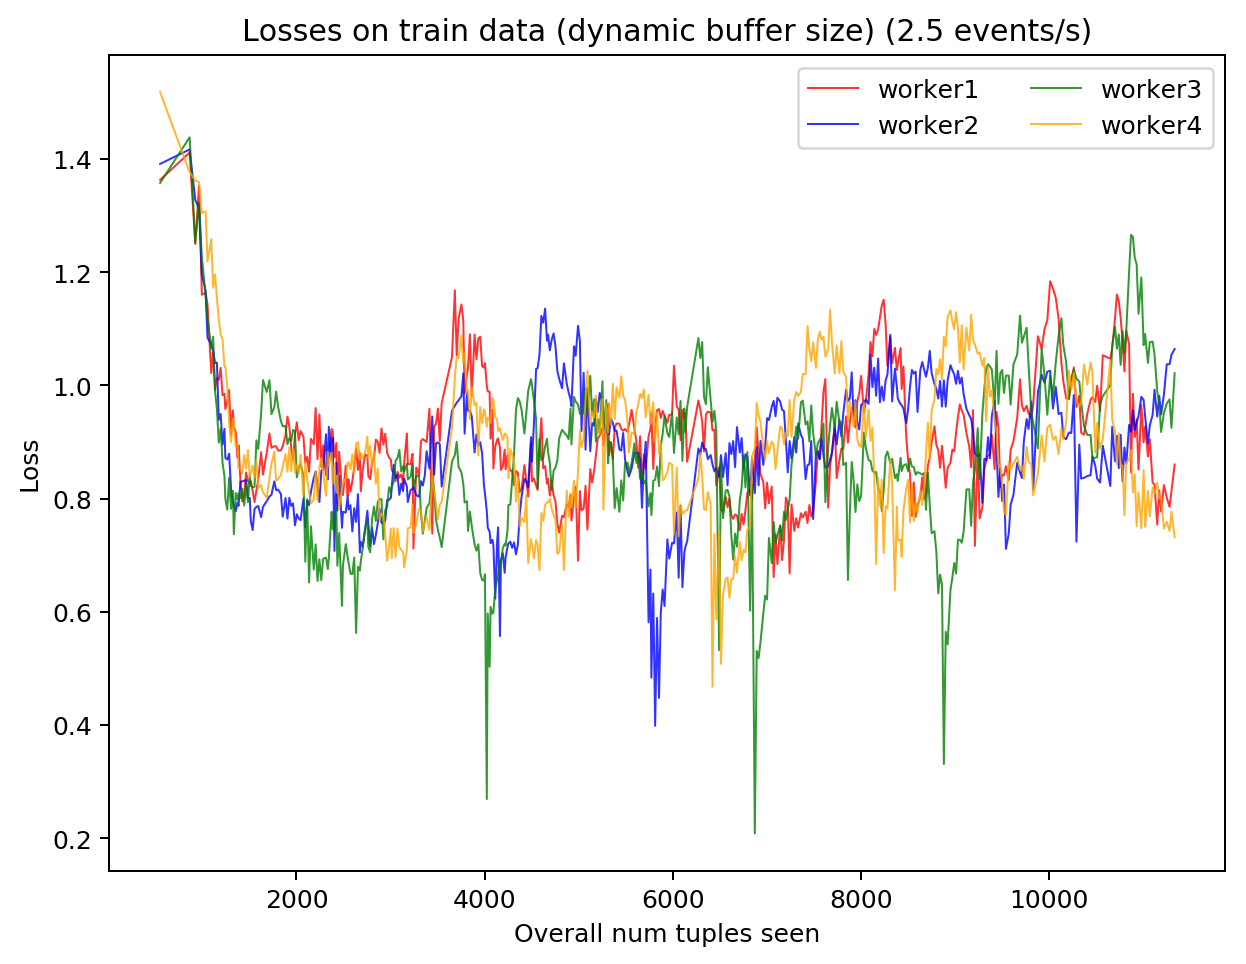

In [549]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, ylim

figure(num=None, figsize=(8, 6), dpi=180, facecolor='w', edgecolor='k')
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'

data['x'] = [i for i in range(len(data))]

# create a color palette
palette = ['red', 'blue', 'green', 'orange', 'purple']

for i in range(numPartitions - 1):
    colY = 'loss' + str(i)
    colX = 'numTuplesSeen' + str(i)
    
    isServerPartition = i == numPartitions - 1
    alpha = 0.8
    label = 'server' if isServerPartition else 'worker'+str(i+1)
    linewidth = 0.8
    plt.plot(data[colX], data[colY], marker='', color=palette[i], linewidth=linewidth, alpha=alpha, label=label)

#ylim(0, 1e-4)
plt.title('Losses on train data (dynamic buffer size) (2.5 events/s)')
plt.ylabel('Loss')
plt.xlabel('Overall num tuples seen')
plt.legend(loc=1, ncol=2)
plt.show()

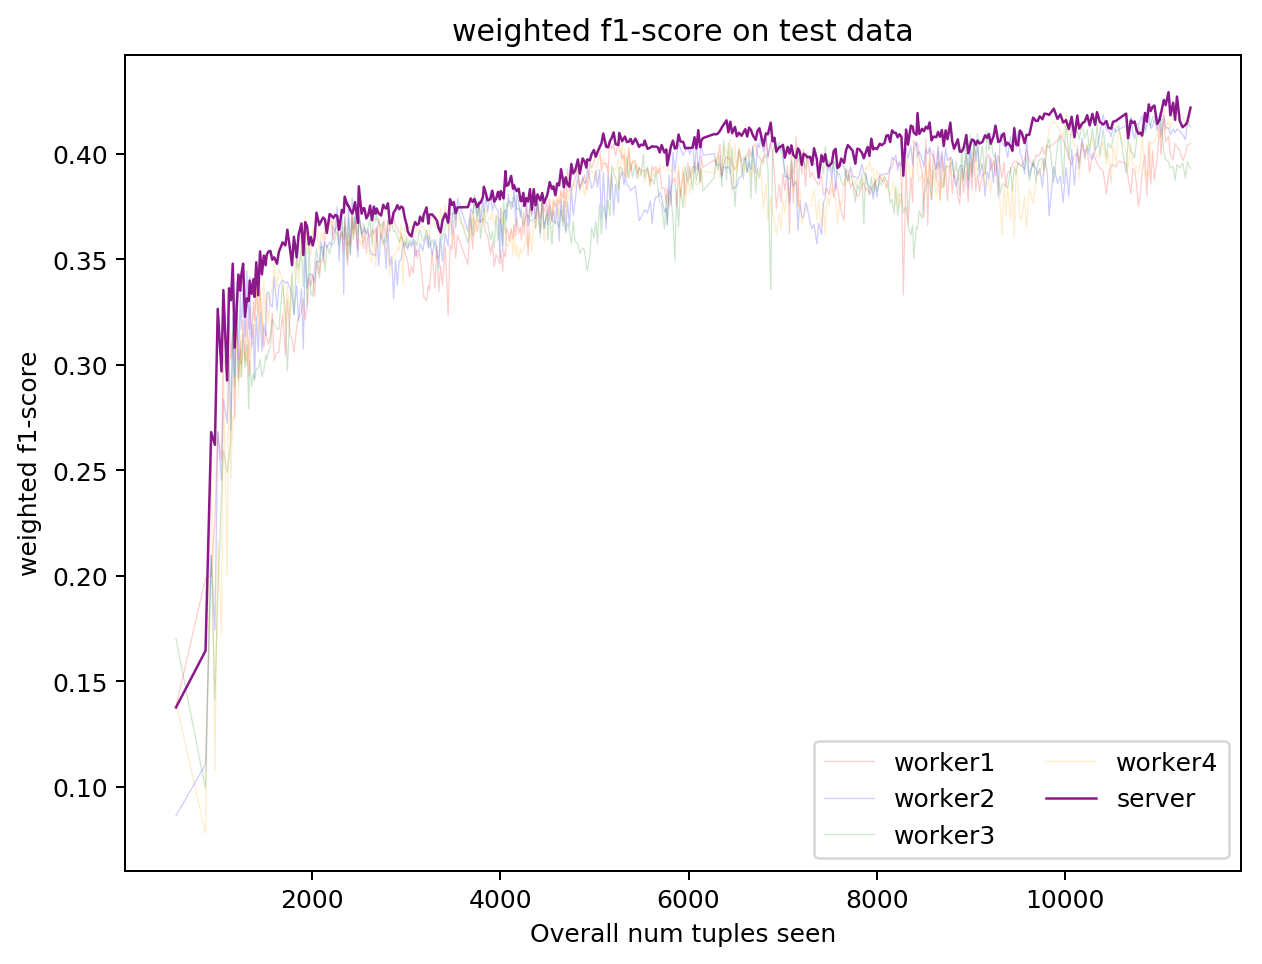

In [510]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, ylim

figure(num=None, figsize=(8, 6), dpi=180, facecolor='w', edgecolor='k')
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'

data['x'] = [i for i in range(len(data))]

# create a color palette
palette = ['red', 'blue', 'green', 'orange', 'purple']

for i in range(numPartitions):
    colY = 'fMesaure' + str(i)
    colX = 'numTuplesSeen' + str(i)
    
    isServerPartition = i == numPartitions - 1
    alpha = 0.9 if isServerPartition else 0.2
    label = 'server' if isServerPartition else 'worker'+str(i+1)
    linewidth = 1 if isServerPartition else 0.5
    plt.plot(data[colX], data[colY], marker='', color=palette[i], linewidth=linewidth, alpha=alpha, label=label)

#ylim(0, 1e-4)
plt.title('weighted f1-score on test data')
plt.ylabel('weighted f1-score')
plt.xlabel('Overall num tuples seen')
plt.legend(loc=4, ncol=2)
plt.show()

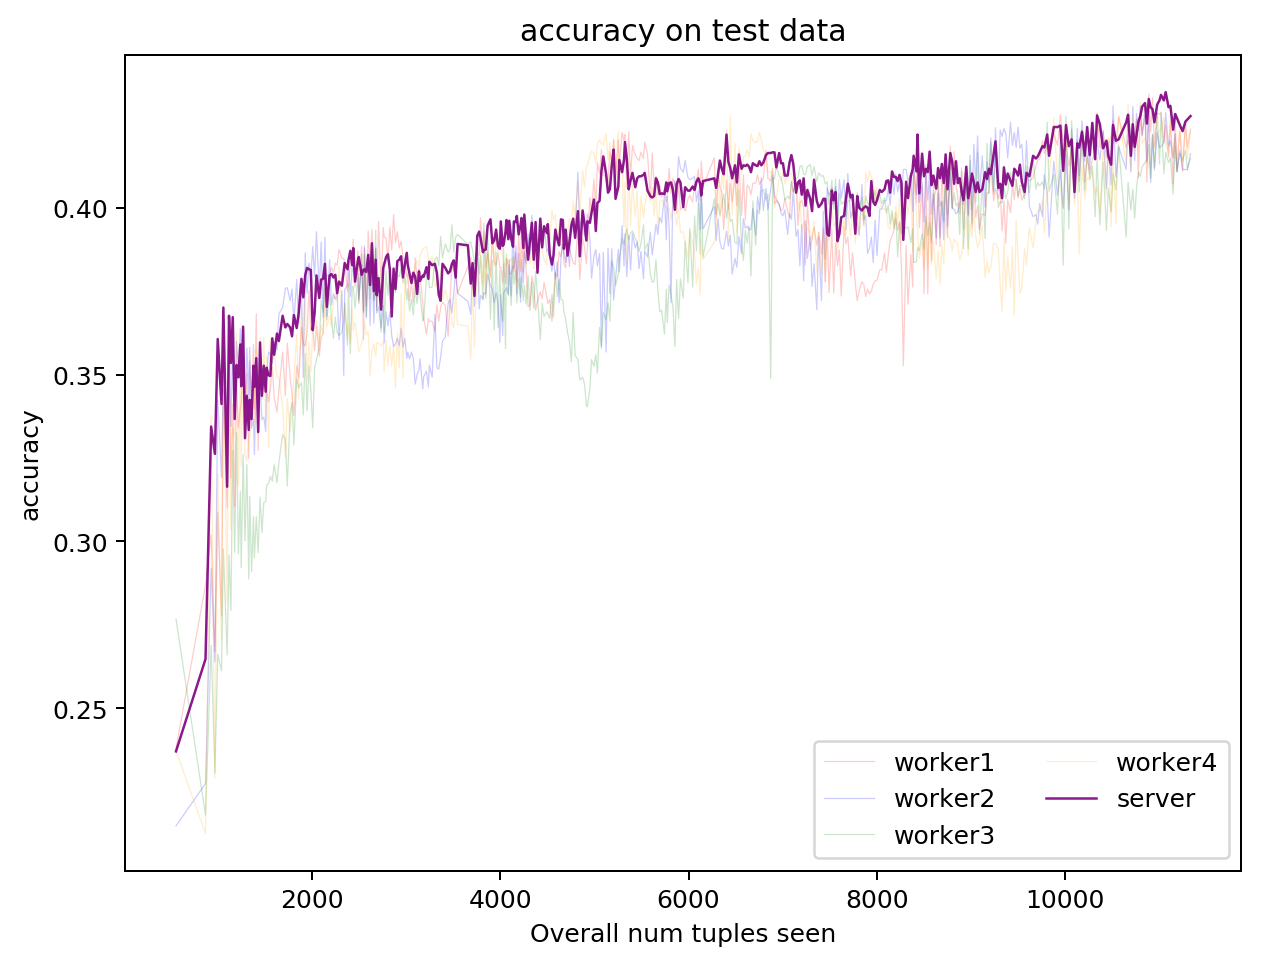

In [511]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, ylim

figure(num=None, figsize=(8, 6), dpi=180, facecolor='w', edgecolor='k')
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'

data['x'] = [i for i in range(len(data))]

# create a color palette
palette = ['red', 'blue', 'green', 'orange', 'purple']

for i in range(numPartitions):
    colY = 'accuracy' + str(i)
    colX = 'numTuplesSeen' + str(i)
    
    isServerPartition = i == numPartitions - 1
    alpha = 0.9 if isServerPartition else 0.2
    label = 'server' if isServerPartition else 'worker'+str(i+1)
    linewidth = 1 if isServerPartition else 0.5
    plt.plot(data[colX], data[colY], marker='', color=palette[i], linewidth=linewidth, alpha=alpha, label=label)

#ylim(0, 1e-4)
plt.title('accuracy on test data')
plt.ylabel('accuracy')
plt.xlabel('Overall num tuples seen')
plt.legend(loc=4, ncol=2)
plt.show()